## Black-Scholes equation

The Black-Scholes differential equation, in terms of $x$ and $\tau$, for an european option call is defined as:

$$
    \frac{\partial U}{\partial \tau} = \frac{\sigma^{2}}{2} \frac{\partial^{2} U}{\partial x^{2}} + \left(r - \frac{\sigma^{2}}{2}\right) \frac{\partial U}{\partial x} - r U
$$


With the following boundary conditions:

\begin{cases}
    U(x, 0) = \max(e^ x - K, 0) \\
    \lim_{x \to - \infty} U(x, \tau) = 0 \\
    U(x, \tau) \approx e^ x - K e^ {- r \tau} \quad \text{for} \quad x \to + \infty
\end{cases}

Let's solve it again using a resampling train points method.

In [1]:
# Importing libraries
import deepxde as xde
import numpy as np
import matplotlib.pyplot as plt

plt.style.use("fast")

Using backend: pytorch
Other supported backends: tensorflow.compat.v1, tensorflow, jax, paddle.
paddle supports more examples now and is recommended.


In [2]:
# Constants
K = 200 # Strike
T = 1 # Time to maturity
sigma = 0.3 # Volatility
r = 0.05 # Risk-free interest rate

# Limits of S (and x)
S_min = 0.1 * K
S_max = 3 * K
x_min = np.log(S_min)
x_max = np.log(S_max)

In [3]:
# Defining a GeometryXTime instance
geom = xde.geometry.Interval(x_min, x_max)
timedomain = xde.geometry.TimeDomain(0, T)
geomtime = xde.geometry.GeometryXTime(geom, timedomain)

In [4]:
# Defining the Black-Scholes residual
def Black_Scholes_differential_equation_residual(xtau, U):
    
    dUdt = xde.grad.jacobian(U, xtau, i = 0, j = 1)
    dUdx = xde.grad.jacobian(U, xtau, i = 0, j = 0)
    d2Udx2 = xde.grad.hessian(U, xtau, i = 0, j = 0)

    return dUdt - sigma ** 2 / 2 * d2Udx2 - (r - sigma ** 2 / 2) * dUdx + r * U # Residual

In [5]:
# Defining the boundary and initial conditions
initial_condition = xde.icbc.IC(
    geom = geomtime,
    func = lambda xtau: np.maximum(np.exp(xtau[:, 0:1]) - K, 0),
    on_initial = lambda _, on_initial: on_initial
)

boundary_condition_lower = xde.icbc.DirichletBC(
    geom = geomtime,
    func = lambda _: 0,
    on_boundary = lambda xtau, on_boundary: on_boundary and xde.utils.isclose(xtau[0], x_min)
)

boundary_condition_upper = xde.icbc.DirichletBC(
    geom = geomtime,
    func = lambda xtau: np.exp(xtau[:, 0:1]) - K * np.exp(- r * xtau[:, 1:2]),
    on_boundary = lambda xtau, on_boundary: on_boundary and xde.utils.isclose(xtau[0], x_max)
)

In [6]:
# Defining the dataset
data = xde.data.TimePDE(geometryxtime = geomtime,
                        pde = Black_Scholes_differential_equation_residual,
                        ic_bcs = [initial_condition, boundary_condition_lower, boundary_condition_upper],
                        num_domain = 5_000,
                        num_boundary = 500,
                        num_initial = 250,
                        num_test = 5_000)

In [7]:
# Defining the network and the model
network = xde.nn.FNN(layer_sizes = [2] + [30] * 3 + [1],
                     activation = "tanh",
                     kernel_initializer = "Glorot normal")

model = xde.Model(data, network)

Compiling model...
'compile' took 3.472783 s

Training model...

Step      Train loss                                  Test loss                                   Test metric
0         [2.53e-03, 1.22e+04, 1.92e-03, 1.64e+05]    [2.27e-03, 1.22e+04, 1.92e-03, 1.64e+05]    []  
1000      [3.34e+00, 9.76e+03, 1.34e+03, 1.36e+05]    [3.34e+00, 9.76e+03, 1.34e+03, 1.36e+05]    []  
2000      [2.35e+01, 6.75e+03, 5.89e-01, 1.15e+05]    [2.38e+01, 6.75e+03, 5.89e-01, 1.15e+05]    []  
3000      [1.26e+01, 4.87e+03, 1.90e-01, 9.49e+04]    [9.93e+00, 4.87e+03, 1.90e-01, 9.49e+04]    []  
4000      [1.41e+01, 3.50e+03, 1.05e-02, 7.80e+04]    [1.29e+01, 3.50e+03, 1.05e-02, 7.80e+04]    []  
5000      [2.23e+01, 2.47e+03, 5.66e-03, 6.31e+04]    [2.11e+01, 2.47e+03, 5.66e-03, 6.31e+04]    []  
6000      [3.34e+01, 1.67e+03, 3.31e-03, 5.00e+04]    [3.23e+01, 1.67e+03, 3.31e-03, 5.00e+04]    []  
7000      [4.77e+01, 1.09e+03, 4.50e-03, 3.87e+04]    [4.71e+01, 1.09e+03, 4.50e-03, 3.87e+04]    []  
8

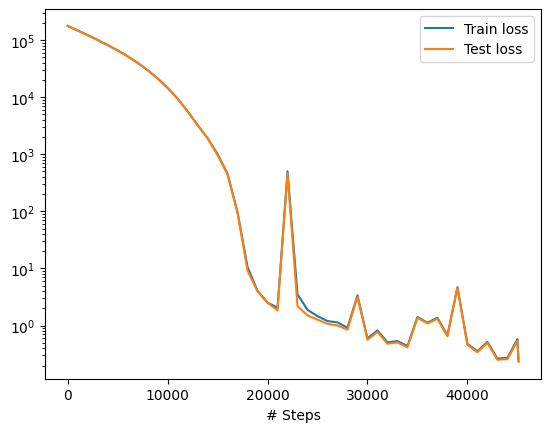

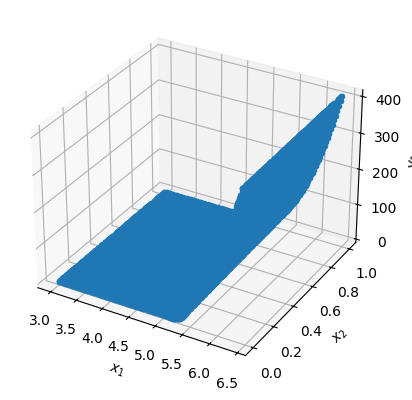

In [8]:
# Training the model
pde_resampler = xde.callbacks.PDEPointResampler(period = 15_000)

# Phase I: Adam optimizer
model.compile("adam", lr = 1e-03)
losshistory, train_state = model.train(iterations = 45_000,
                                       callbacks = [pde_resampler])

# Phase II: L-BFGS fine-tuning
model.compile("L-BFGS")
losshistory, train_state = model.train()

# Loss history results
xde.utils.plot_loss_history(losshistory)
xde.utils.plot_best_state(train_state)
plt.show()